https://petewarden.com/2017/12/14/how-many-images-do-you-need-to-train-a-neural-network/
    

# Trying to Learn Neural Network with Tensorflow

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

import cv2

from PIL import Image

Log directory

In [3]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [4]:
logdir

'tf_logs/run-20181218103854/'

Données 

In [5]:
%%time
from glob import glob
import os

imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))

Wall time: 35 ms


In [6]:
%%time
name_to_label ={'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]} #Pour labeliser facilement

data_base={'data': [], 'label' : [],'nom_label' :[],'image':[]}
for file in ls_path:                        #On parcours tous les fichiers                
    im = np.array(Image.open(file))[:,:,3]   #On charge l'image
  
    im = cv2.resize(im, (64, 64))             #On met au bon format de pixels
    name= file.split('\\')[1].split('_')[0] #On extrait le type
    
    data_aug = 1                             # Si on veut faire de la data_aug
    for i in range(data_aug):
        num_rows, num_cols = im.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), i*90, 1)
        im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
        data_base['data']+=[np.ndarray.flatten(im_rotation)]
        data_base['label']+=[name_to_label[name]]
        data_base['nom_label']+=[name]
        data_base['image']+=[im_rotation]
data_base['data']=np.array(data_base['data'])
data_base['label']=np.array(data_base['label'])
data_base['nom_label']=np.array(data_base['nom_label'])
data_base['image']=np.array(data_base['image'])
    

Wall time: 9.52 s


data_base

In [7]:
data_base['data'].shape

(1124, 4096)

In [44]:
# Tuple with height and width of images used to reshape arrays.
img_shape = data_base['image'][1].shape

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data_base['image'][1].size

# Number of classes, one class for each of 10 digits.
num_classes = 4

In [45]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,  figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0},Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

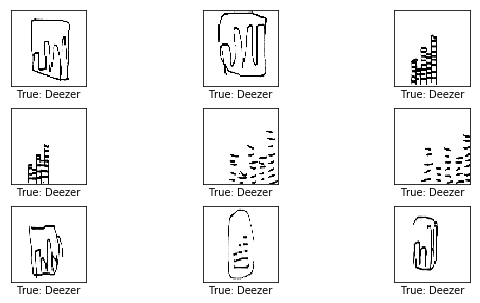

In [46]:
# Get the first images from the test-set.
images = data_base['image'][5:14]

# Get the true classes for those images.
cls_true = data_base['nom_label'][5:14]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [47]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

y_true = tf.placeholder(tf.float32, [None, num_classes])

y_true_cls = tf.placeholder(tf.int64, [None])

weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

biases = tf.Variable(tf.zeros([num_classes]))

logits = tf.matmul(x, weights) + biases

y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

https://en.wikipedia.org/wiki/Cross-entropy_method

In [48]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [49]:
cost = tf.reduce_mean(cross_entropy)

In [50]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [51]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [52]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [53]:
cost_summary = tf.summary.scalar('COST', cost)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# RUN

In [54]:
session = tf.Session()

In [55]:
session.run(tf.global_variables_initializer())

In [56]:
batch_size = 100

In [57]:
X= data_base['data']
Y= data_base['label']

In [58]:
from sklearn.cross_validation import train_test_split
np.random.seed(1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3,
                                                random_state=0)

Data Augmentation but only on Train data

In [59]:
def _unflatten(flat_values, prototype, offset):
    if isinstance(prototype, np.ndarray):
        shape = prototype.shape
        new_offset = offset + np.product(shape)
        value = flat_values[offset:new_offset].reshape(shape)
        return value, new_offset
    else:
        result = []
        for value in prototype:
            value, offset = _unflatten(flat_values, value, offset)
            result.append(value)
        return result, offset

def unflatten(flat_values, prototype):
    # unflatten np.ndarray to nested lists with structure of prototype
    result, offset = _unflatten(flat_values, prototype, 0)
    assert(offset == len(flat_values))
    return result

In [60]:
def data_aug_im(X,y,im_prototype,nombre,deg) :
    R_X=X
    R_y=y
    for i in range(len(X)) :
        im=unflatten(X[i],im_prototype)
        lab=y[i]
        for j in range(nombre) :
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), (j+1)*nombre, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
            
            R_X=np.concatenate((R_X,np.ndarray.flatten(im_rotation).reshape(1,-1)), axis=0)
            R_y=np.concatenate((R_y,lab.reshape(1,-1)), axis=0)
    return(R_X,R_y)

In [61]:
Xtrain.shape,ytrain.shape

((786, 4096), (786, 4))

In [62]:
Xtrain_aug,ytrain_aug=data_aug_im(Xtrain,ytrain,data_base['image'][0],3,90)

In [63]:
Xtrain_aug.shape , ytrain_aug.shape

((3144, 4096), (3144, 4))

In [64]:
def optimize(num_iterations,use_X,use_y):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        
        x_batch = use_X
        y_true_batch = use_y
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        if i % 2 ==0 :
            summary_str = cost_summary.eval(feed_dict=feed_dict_train)
            step = epoch * num_iterations + i
            file_writer.add_summary(summary_str, step)

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [65]:
j={'[1 0 0 0]':0,'[0 1 0 0]':1, '[0 0 1 0]':2,'[0 0 0 1]':3}

dic={'[1 0 0 0]':0,'[0 1 0 0]':1, '[0 0 1 0]':2,'[0 0 0 1]':3}
feed_dict_test = {x: Xtest,
                  y_true: ytest,
                  y_true_cls: [dic[str(a)] for a in ytest]}

In [66]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [67]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = feed_dict_test[y_true_cls]
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [68]:
label_to_name ={0:'Deezer',1:'Messenger',2:'Facebook',3:'Tinder'}

In [69]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    
    images = np.tile(Xtest[incorrect],(9,1))
    
    # Get the predicted classes for those images.
    cls_pred = np.tile(cls_pred[incorrect],9)
    
    # Get the true classes for those images.
    cls_true = np.tile(np.array(feed_dict_test[y_true_cls])[incorrect],9)
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=[label_to_name[a] for a in cls_true[0:9]],
                cls_pred=[label_to_name[a] for a in cls_pred[0:9]])

In [70]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(2, 1)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [71]:
print_accuracy()

Accuracy on test-set: 20.4%


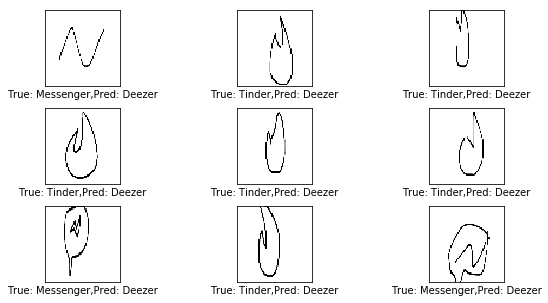

In [72]:
plot_example_errors()

In [76]:
optimize(2,Xtrain,ytrain)

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [ ]:
print_accuracy()

In [ ]:
plot_example_errors()

In [ ]:
plot_weights()

In [ ]:
optimize(10,Xtrain_aug,ytrain_aug)

In [ ]:
print_accuracy()

In [ ]:
plot_weights()

In [ ]:
plot_example_errors()

In [ ]:
#num_iterations=1000
optimize(1000,Xtrain_aug,ytrain_aug)

In [ ]:
print_accuracy()

In [ ]:
plot_weights()

In [ ]:
print_confusion_matrix()